This is my attempt to cluster Trump supporters to try and understand what _types_ of Trump supporters exist. This is supposed to be a companion to my answer on Quora to the question "What types of people make up the largest portion of Trump supporters?"

As always, the code is hidden by default. You can click the beautiful button below to view it.

In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="I want to look at the code.">
 </form>'
)

In [10]:
library(haven)
library(dplyr)
library(ggplot2)
library(cluster)
library(reshape2)
setwd("~/Documents/Writing/Trump Supporter/")

I'm using the CCES 2018 dataset, primarily because of the high number of respondents. The guide to this dataset (including the list of columns and options) can be found [here](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/ZSBZ7K/WZWCZ1&version=6.0).

## Trump supporters
Of course, a definition of "Trump supporter" is required. If there was a feelings thermometer rating to go with, that would be our clear indicator, but the CCES 2018 doesn't have that. So, our "Trump supporters" will be people who think Trump is doing a great job. The CCES 2018 asks: "Do you approve or disapprove of the way Donald Trump is handling his job as President?". The people who answer "Strongly Approve" to that question are treated here as Trump supporters.

### Limitations
I'm aware that this is an imperfect definition, because there may be people who approve of the job Pres. Trump is doing but do not "support" him in the sense that the question asks. But I'm sticking with it because I think the wealth of responses available in this dataset trumps (ahem) the better idea I might get with a dataset that has more direct feelings about Trump. Also, note the asymmetry in the imperfect definition: "Trump supporters" are almost all likely to approve of the job he's doing, even if all those who approve of the job he's doing aren't "Trump supporters". Basically, a set of Trump supporters is definitely a _subset_ of my data, so I'm unlikely to be missing any Trump supporters: at worst, I'm classifying some people, who approve of the job he's doing, as people who support him. They can write a blog about it.

Still, I'd like to narrow things down, and that's why I'm limiting this definition of "Trump supporter" to respondents who "Strongly Approve" of the president's job.

Here's a rough outline of the methodology:

## Methodology

1. Separate data into "profile" variables and "opinion" variables: profile variables tell us about the social and economic identity of the respondents: their age, gender, ethnicity, where they get their news from, whether they're a union member, etc. "Opinion" variables tell us about the, spoiler alert, opinions the respondents hold: Do they support banning all abortions? Do they support building a wall? Do they support the tax cuts? etc.

2. Cluster the respondents using the "opinion" variables, because that can give us the most insight into who they are as Trump supporters. I'll be doing a hierarchical clustering based on gower distance (which, since all the columns here are nominal, is equivalent to the dice coefficient). A much better explanation than I can give is [here](https://online.stat.psu.edu/stat505/lesson/14/14.3) and [here](https://stats.stackexchange.com/questions/55798/what-is-the-optimal-distance-function-for-individuals-when-attributes-are-nomina/55802#55802) and [here](https://stats.stackexchange.com/questions/297121/measures-of-association-between-nominal-variables-with-the-same-categories-pair/297206#297206). Applied here, it's a measure of relative agreement in essence: The gower distance between two respondents (caseid's) in our dataset will be dependent on how many questions they agree on, vs. how many questions they disagree.
3. Profile these clusters, using the "opinion" as well as "profile" variables: essentially, break down the clusters by social identity as well as support for different Trump policies which can give us insight into their beliefs.

The idea is to establish clusters of Trump supporters using their political opinions, and then profile them to understand their political as well as social identity.

First, I'm going to separate out the profile variables, and create a dissimilarity matrix according to gower distance.

In [12]:
# Load the data and choose required columns
cces_ts <- readRDS("Data/cces_2018_data.RDS")
cces_profile <- cces_ts %>% select(caseid=caseid,
                           birthyr,
                           gender,
                           sexuality,
                           educ,
                           race,
                           ideo5,
                           pew_churatd,
                           pew_bornagain,
                           newsint,
                           union,
                           investor,
                           tvuse=CC18_300_2 ,
                           newspaper=CC18_300_3,
                           radiouse=CC18_300_4,
                           videoabtpolitics=CC18_300d_3,
                           fwdpolitics=CC18_300d_5,
)

cces <- cces_ts %>% select(caseid=caseid,
                           trumpapprove=CC18_308a,
                           policespending=CC18_426_4,
                           alwaysallowabortion=CC18_321a,
                           exceptionabortion=CC18_321b,
                           allowemployersdenyabortion=CC18_321d,
                           allabortionsillegal=CC18_321f,
                           borderspendingpluswall=CC18_322a,
                           daca=CC18_322b,
                           reducelegalimmigration=CC18_322c_new,
                           dacawallandreducelegal=CC18_322d_new,
                           reentryprison=CC18_322f,
                           cutcorporatetax=CC18_325a,
                           cuttaxeslt500k=CC18_325e_new,
                           cuttaxesgt500k=CC18_325f_new,
                           medicareforall=CC18_327a,
                           repealobamacare=CC18_327c,
                           partialrepeallargeempl=CC18_327d,
                           chinatariff=CC18_331a,
                           allowkeystone=CC18_332b,
                           withdrawparis=CC18_332c,
                           withdrawtpp = CC18_332e,
                           selfideology=CC18_334A,
                           russiacollusion=CC18_335,
                           epaco2=CC18_415a,
                           environprot = CC18_415d,
                           muslimban=CC18_417_c,
                           blackswithoutfavours=CC18_422e,
                           blacksgottenlessthandeserve=CC18_422g,
                           blackstryharder=CC18_422h,
                           whiteprivilege=CC18_422a,
                           racismrare = CC18_422b,
                           feministreasonable=CC18_422d,
                           welfarespend=CC18_426_1,
                           banassault=CC18_320c,
                           backgroundchecks=CC18_320a,
                           easierconcealed=CC18_320d,
                           transban=CC18_417_d,
                           trumpapprovepost=CC18_app_dtrmp_post,
                           womenunreasonablesexism=CC18_422c) %>% filter(!is.na(trumpapprove),!is.na(trumpapprovepost))


In [14]:
# Start with people who "Strongly Approve" of Trump's job as President.
cces <- cces %>% filter(trumpapprove == 2)
# colSums(is.na(cces))
# Remove all the NAs from these columns - this leaves me with close to 7k responses of Trump supporters.
cces <- cces %>% na.exclude()
cces_cluster <- cces %>% dplyr::select(-trumpapprove) %>% 
  mutate_all(as.character())
# Set Case ID as row number so it won't be clustered
caseids <- cces$caseid
cces_cluster$caseid <- NULL
# All of these variables, because they came from a .dta file, are in haven_labelled format. 
# Making them factors so R can deal with them.
for(i in 1:ncol(cces_cluster))
{
  cces_cluster[,i] <- as_factor(cces_cluster[,i])
}

#Create a distance matrix using gower distance and the given dataset
distmatrix <- daisy(x = cces_cluster,metric = "gower")

In [ ]:
After creating this distance matrix.

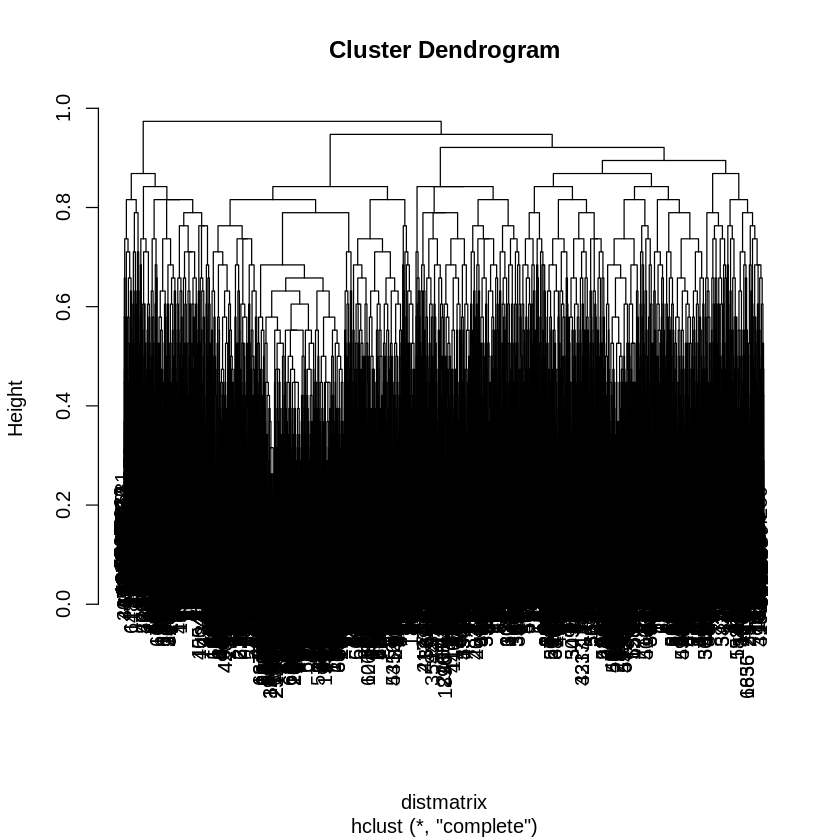

In [18]:
# Plotting the dendogram to see how many clusters. Complete linkage gives the best results.
plot(hclust(distmatrix,method = "complete"))